In [15]:
# ALL THE REQUIRED IMPORTS
import mxnet as mx
from mxnet.gluon import nn
from mxnet import gluon, autograd
from mxnet.gluon.data.vision import transforms
from sklearn.svm import OneClassSVM
from sklearn.metrics import pairwise_distances
import numpy as np
import mxnet as mx
from mxnet import recordio
import matplotlib.pyplot as plt
from mxnet import nd

# GLOBAL PATH VARIABLES
PATH_REC = "train.rec"
PATH_IDX = "train.idx"

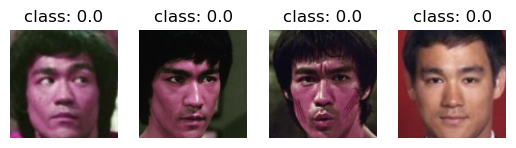

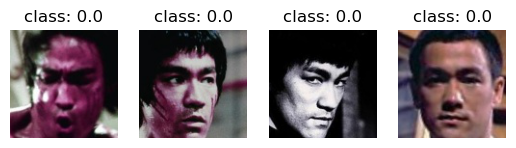

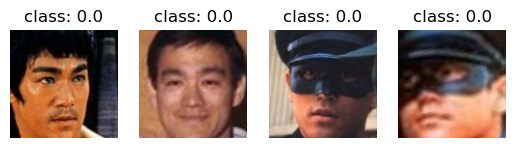

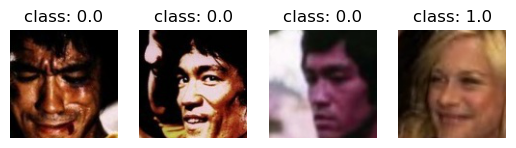

In [16]:
#Iterate and Print Images in a data set in a batch of 4
data_iter = mx.image.ImageIter(
    batch_size=4,
    data_shape=(3, 112, 112),
    path_imgrec=PATH_REC,
    path_imgidx=PATH_IDX,
)
data_iter.reset()
for j in range(4): # 409623 images.
    batch = data_iter.next()
    data = batch.data[0]
#     print(batch) 
    label = batch.label[0].asnumpy()
    for i in range(4):
        ax = plt.subplot(1, 4, i + 1)
        plt.imshow(data[i].asnumpy().astype(np.uint8).transpose((1, 2, 0)))
        ax.set_title("class: " + str(label[i]))
        plt.axis("off")
    plt.show()

In [19]:
# Define the DCNN architecture
class DCNN(nn.Block):
    def __init__(self, **kwargs):
        super(DCNN, self).__init__(**kwargs)
        self.net = nn.Sequential()
        
        # Block 1
        self.net.add(
            nn.Conv2D(32, kernel_size=3, strides=1, padding=1),  # Conv11
            nn.Conv2D(64, kernel_size=3, strides=1, padding=1),  # Conv12
            nn.Conv2D(64, kernel_size=3, strides=1, padding=1),  # Conv13
            nn.MaxPool2D(pool_size=2, strides=2)                  # Pool1
        )

        # Block 2
        self.net.add(
            nn.Conv2D(64, kernel_size=3, strides=1, padding=1),  # Conv21
            nn.Conv2D(128, kernel_size=3, strides=1, padding=1), # Conv22
            nn.Conv2D(128, kernel_size=3, strides=1, padding=1), # Conv23
            nn.MaxPool2D(pool_size=2, strides=2)                 # Pool2
        )

        # Block 3
        self.net.add(
            nn.Conv2D(96, kernel_size=3, strides=1, padding=1),  # Conv31
            nn.Conv2D(192, kernel_size=3, strides=1, padding=1), # Conv32
            nn.Conv2D(192, kernel_size=3, strides=1, padding=1), # Conv33
            nn.MaxPool2D(pool_size=2, strides=2)                 # Pool3
        )

        # Block 4
        self.net.add(
            nn.Conv2D(128, kernel_size=3, strides=1, padding=1), # Conv41
            nn.Conv2D(256, kernel_size=3, strides=1, padding=1), # Conv42
            nn.Conv2D(256, kernel_size=3, strides=1, padding=1), # Conv43
            nn.MaxPool2D(pool_size=2, strides=2)                 # Pool4
        )

        # Block 5
        self.net.add(
            nn.Conv2D(160, kernel_size=3, strides=1, padding=1), # Conv51
            nn.Conv2D(320, kernel_size=3, strides=1, padding=1), # Conv52
            nn.Conv2D(320, kernel_size=3, strides=1, padding=1), # Conv53
            nn.AvgPool2D(pool_size=6)                            # Pool5
        )

        # Fully connected layer and dropout
        self.net.add(
            nn.Dropout(0.4),                 # Dropout 40%
            nn.Dense(10548),                 # FC6 (fully connected)
        )

    def forward(self, x):
        return self.net(x)

In [20]:
#Improved VLADCNN Architecture
from mxnet.gluon import nn
from mxnet import initializer

class VLADDCNN(nn.Block):
    def __init__(self, num_classes=10548, **kwargs):
        super(VLADDCNN, self).__init__(**kwargs)
        with self.name_scope():
            # First Convolutional Block
            self.conv1 = nn.HybridSequential()
            self.conv1.add(
                nn.Conv2D(32, kernel_size=3, strides=1, padding=1),
                nn.PReLU(),
                nn.Conv2D(64, kernel_size=3, strides=1, padding=1),
                nn.PReLU(),
                nn.Conv2D(64, kernel_size=3, strides=1, padding=1),
                nn.PReLU(),
                nn.MaxPool2D(pool_size=2, strides=2)
            )
            
            # Second Convolutional Block
            self.conv2 = nn.HybridSequential()
            self.conv2.add(
                nn.Conv2D(64, kernel_size=3, strides=1, padding=1),
                nn.PReLU(),
                nn.Conv2D(128, kernel_size=3, strides=1, padding=1),
                nn.PReLU(),
                nn.Conv2D(128, kernel_size=3, strides=1, padding=1),
                nn.PReLU(),
                nn.MaxPool2D(pool_size=2, strides=2)
            )
            
            # Third Convolutional Block
            self.conv3 = nn.HybridSequential()
            self.conv3.add(
                nn.Conv2D(96, kernel_size=3, strides=1, padding=1),
                nn.PReLU(),
                nn.Conv2D(192, kernel_size=3, strides=1, padding=1),
                nn.PReLU(),
                nn.Conv2D(192, kernel_size=3, strides=1, padding=1),
                nn.PReLU(),
                nn.MaxPool2D(pool_size=2, strides=2)
            )
            
            # Fourth Convolutional Block
            self.conv4 = nn.HybridSequential()
            self.conv4.add(
                nn.Conv2D(128, kernel_size=3, strides=1, padding=1),
                nn.PReLU(),
                nn.Conv2D(256, kernel_size=3, strides=1, padding=1),
                nn.PReLU(),
                nn.Conv2D(256, kernel_size=3, strides=1, padding=1),
                nn.PReLU(),
                nn.MaxPool2D(pool_size=2, strides=2)
            )
            
            # Fifth Convolutional Block
            self.conv5 = nn.HybridSequential()
            self.conv5.add(
                nn.Conv2D(160, kernel_size=3, strides=1, padding=1),
                nn.PReLU(),
                nn.Conv2D(320, kernel_size=3, strides=1, padding=1),
                nn.PReLU(),
                nn.Conv2D(320, kernel_size=3, strides=1, padding=1),
                nn.PReLU(),
                nn.AvgPool2D(pool_size=6)
            )
            
            # Fully Connected Layer
            self.fc = nn.HybridSequential()
            self.fc.add(
                nn.Dropout(0.4),
                nn.Dense(num_classes, weight_initializer=initializer.Xavier())
            )
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
    # Get the shape of the feature map
        batch_size, _, h, w = x.shape
    
    # Generate normalized spatial coordinates with the same batch size
        x_coords = (nd.arange(w) / w - 0.5).reshape((1, 1, 1, w)).repeat(repeats=h, axis=2).repeat(repeats=batch_size, axis=0)
        y_coords = (nd.arange(h) / h - 0.5).reshape((1, 1, h, 1)).repeat(repeats=w, axis=3).repeat(repeats=batch_size, axis=0)
    
    # Concatenate coordinates with features along the channel dimension
        x = nd.concat(x, x_coords, y_coords, dim=1)
    
    # Apply square root normalization with sign preservation
        x = nd.sign(x) * nd.sqrt(nd.abs(x))
    
    # Pass through fully connected layer
        x = self.fc(x)
        return x



# Instantiate the model
num_classes = 10548  # Replace with actual number of classes as needed


In [21]:
# Initialize the network
# net = DCNN()
net = VLADDCNN(num_classes=num_classes)
net.initialize(mx.init.Xavier())

# Prepare the data iterator
data_iter = mx.image.ImageIter(
    batch_size=128,  
    data_shape=(3, 100, 100),  
    path_imgrec=PATH_REC,
    path_imgidx=PATH_IDX,
    rand_crop=True,  
    rand_mirror=True,
)

trainer = gluon.Trainer(
    net.collect_params(),
    'sgd',
    {'learning_rate': 0.01, 'momentum': 0.9}
)

for name, param in net.collect_params().items():
    if 'dense' in name:  # Adjust this to match your final layer's name
        param.wd_mult = 5e-4
    else:
        param.wd_mult = 0  # No weight decay for convolutional layers

# Learning rate scheduler
lr_scheduler = mx.lr_scheduler.FactorScheduler(step=100000, factor=0.5)
# trainer.set_learning_rate(lr_scheduler)

# Training loop placeholder
def train(num_epochs):
    total_iterations = 0  # Counter for total iterations
    for epoch in range(num_epochs):
        data_iter.reset()
        for batch in data_iter:
            data = batch.data[0].as_in_context(mx.cpu())
            label = batch.label[0].as_in_context(mx.cpu())
            with autograd.record():
                output = net(data)
                loss = gluon.loss.SoftmaxCrossEntropyLoss()(output, label)
                if np.isnan(output.asnumpy()).any():
                    print("NaN detected in output. Terminating algorithm.")
                    break;
            loss.backward()
            trainer.step(batch.data[0].shape[0])  # This will also call the scheduler
            # Increment the total iteration count
            total_iterations += 1
            if(total_iterations==300):
                break
            print(total_iterations)
            # Update learning rate based on the scheduler
            if total_iterations % 100000 == 0:
                new_lr = lr_scheduler.get_lr(total_iterations)
                trainer.set_learning_rate(new_lr)

        
        print(f'Epoch {epoch + 1} complete. Current Learning Rate: {trainer.learning_rate}')

# Example: Start training
train(num_epochs=1)
net.save_parameters("dcnn_trained.params")

1
2
3
4


KeyboardInterrupt: 

In [ ]:
#Variation of epsilon with 20% and 40% of the Dataset

In [7]:
import mxnet as mx
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_distances

# Define Image Iterator for CASIA-WebFace (first 20% of dataset)
data_iter = mx.image.ImageIter(
    batch_size=4,
    data_shape=(3, 112, 112),
    path_imgrec=PATH_REC,
    path_imgidx=PATH_IDX,
)

# Load first 20% of data
data_iter.reset()
num_images = int(409623)  # assuming total images are 409623
images, labels = [], []
for _ in range(num_images // 4):
    batch = data_iter.next()
    images.extend(batch.data[0].asnumpy())
    labels.extend(batch.label[0].asnumpy())

images = np.array(images)
labels = np.array(labels)

unique_labels = np.unique(labels)


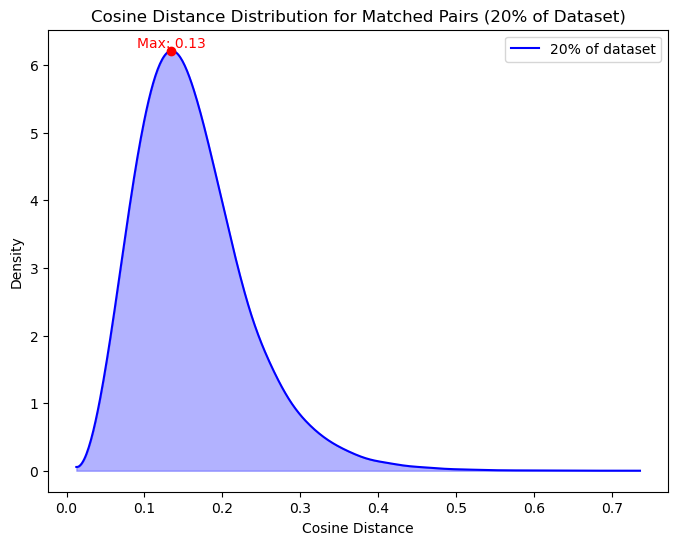

In [ ]:
import mxnet as mx
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_distances
from scipy.interpolate import make_interp_spline

# Define Image Iterator for CASIA-WebFace
data_iter = mx.image.ImageIter(
    batch_size=4,
    data_shape=(3, 112, 112),
    path_imgrec=PATH_REC,
    path_imgidx=PATH_IDX,
)

# Define sampling percentages
percentages = [0.2, 0.4, 0.6, 0.8, 1.0]
num_images_total = 409623  # assuming total images are 409623
images, labels = [], []  # Initialize empty lists for images and labels

for percentage in percentages:
    # Calculate the number of images to add in this iteration
    num_images_to_add = int(0.2 * num_images_total)
    
    for _ in range(num_images_to_add // 4):
        batch = data_iter.next()
        images.extend(batch.data[0].asnumpy())
        labels.extend(batch.label[0].asnumpy())
    
    # Convert cumulative lists to numpy arrays
    images_np = np.array(images)
    labels_np = np.array(labels)
    
    # Get unique labels and sample 100 random subjects
    unique_labels = np.unique(labels_np)
    sampled_labels = random.sample(list(unique_labels), 100)
    sampled_indices = [i for i, lbl in enumerate(labels_np) if lbl in sampled_labels]
    
    # Extract sampled images and labels
    sampled_images = images_np[sampled_indices]
    sampled_labels = labels_np[sampled_indices]
    
    # Placeholder for feature extraction
    extracted_features = sampled_images.reshape(len(sampled_images), -1)  # flatten images
    
    # Compute cosine distances for all matched pairs
    distances = []
    for lbl in sampled_labels:
        idx = np.where(sampled_labels == lbl)[0]
        if len(idx) > 1:
            features = extracted_features[idx]
            pairwise_distances = cosine_distances(features)
            distances.extend(pairwise_distances[np.triu_indices(len(idx), k=1)])  # upper triangle
    
    # Compute histogram and fit spline for smoother curve
    hist, bin_edges = np.histogram(distances, bins=30, density=True)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    
    spline = make_interp_spline(bin_centers, hist, k=3)
    x_smooth = np.linspace(bin_centers.min(), bin_centers.max(), 500)
    y_smooth = spline(x_smooth)
    
    # Find the maximum density point
    max_index = np.argmax(y_smooth)
    max_x = x_smooth[max_index]
    max_y = y_smooth[max_index]
    
    # Plot the spline curve for this percentage
    plt.figure(figsize=(8, 6))
    plt.plot(x_smooth, y_smooth, label=f'{int(percentage * 100)}% of dataset', color='blue')
    plt.fill_between(x_smooth, y_smooth, alpha=0.3, color='blue')
    
    # Mark the maximum density point
    plt.plot(max_x, max_y, 'ro')  # Mark the max point with a red dot
    plt.text(max_x, max_y, f'Max: {max_x:.2f}', ha='center', va='bottom', color='red')
    
    # Set plot titles and labels
    plt.title(f"Cosine Distance Distribution for Matched Pairs ({int(percentage * 100)}% of Dataset)")
    plt.xlabel("Cosine Distance")
    plt.ylabel("Density")
    plt.legend()
    plt.show()